In [2]:
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import gc

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam

import timm
import wandb
from tqdm import tqdm
import os

from sklearn.metrics import f1_score, accuracy_score, classification_report


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


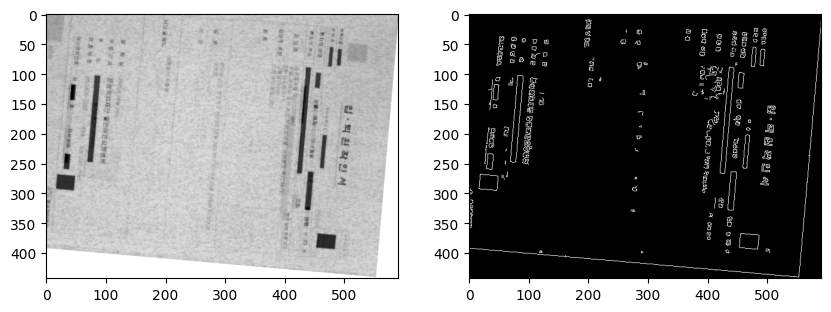

In [3]:
image = cv2.imread('/upstage-cv-classification-cv2/data/test/1f40e905a531d54f.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 100, 200)


image2 = cv2.imread('/upstage-cv-classification-cv2/data/test/feae829823ba76c0.jpg')
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray")

# edge들을 학습시켜보자

- rotate & shift & flip 으로만 증강하자
- test data 도 전처리해야한다.
- 분석해서 3 - 7 만 잘 구분하면 성공한 것

In [4]:
PRE_PATH = '/upstage-cv-classification-cv2/'

# train
TRAIN_CSV_PATH = PRE_PATH + 'data/train.csv'
TRAIN_DF = pd.read_csv(TRAIN_CSV_PATH)
TRAIN_IMAGE_PATH = PRE_PATH + 'data/train'
TRAIN_AUG_IMAGE_PATH = PRE_PATH + 'data/train_edge_aug' # 증강한 이미지들을 담을 폴더명 미리 지정
TRAIN_AUG_CSV_PATH = PRE_PATH + 'data/train_edge_aug.csv'

#valid
VALID_CSV_PATH = PRE_PATH + 'data/valid.csv'
VALID_DF = pd.read_csv(VALID_CSV_PATH)
VALID_IMAGE_PATH = PRE_PATH + 'data/valid'
VALID_AUG_IMAGE_PATH = PRE_PATH + 'data/valid_edge_aug'
VALID_AUG_CSV_PATH = PRE_PATH + 'data/valid_edge_aug.csv'

# test
TEST_CSV_PATH = PRE_PATH + 'data/sample_submission.csv'
TEST_DF = pd.read_csv(TEST_CSV_PATH)
TEST_IMAGE_PATH = PRE_PATH + 'data/test'
TEST_AUG_IMAGE_PATH = PRE_PATH + 'data/test_edge_aug' # TEST 이미지 변환한 것들 담을 폴더 미리 지정

# meta
META_CSV_PATH = PRE_PATH + 'data/meta.csv'
META_DF = pd.read_csv(META_CSV_PATH)

# wandb
WANDB_PROJECT_NAME = 'Candy_preprocessing'
WANDB_RUN_NAME = 'rotate45_effi4'

# meta

In [5]:
meta = pd.read_csv(META_CSV_PATH)

translations = {
        'account_number': '계좌번호',
        'application_for_payment_of_pregnancy_medical_expenses': '건강보험 임신출산 진료비 지급 신청서',
        'car_dashboard': '자동차 계기판',
        'confirmation_of_admission_and_discharge': '입퇴원 확인서',
        'diagnosis': '진단서',
        'driver_lisence': '운전면허증',
        'medical_bill_receipts': '진료비영수증',
        'medical_outpatient_certificate': '통원진료 확인서',
        'national_id_card': '주민등록증',
        'passport': '여권',
        'payment_confirmation': '진료비 납입 확인서',
        'pharmaceutical_receipt': '약제비 영수증',
        'prescription': '처방전',
        'resume': '이력서',
        'statement_of_opinion': '소견서',
        'vehicle_registration_certificate': '자동차 등록증',
        'vehicle_registration_plate': '자동차 번호판'
}

meta['kr_class_name'] = meta['class_name'].map(lambda x : translations[x])

# 1. agumentation

In [6]:
# 회전 변환 + 수평 뒤집기
hf_rotate_000 = A.Compose([A.HorizontalFlip(p=1)])
hf_rotate_045 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(0, 45), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
hf_rotate_090 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(45, 90), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
hf_rotate_135 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(90, 135), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
hf_rotate_180 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(135, 180), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
hf_rotate_225 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(180, 225), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
hf_rotate_270 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(225, 270), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
hf_rotate_315 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(270, 315), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])

# 회전 변환
rotate_000 = A.Compose([])
rotate_045 = A.Compose([A.Rotate(limit=(0, 45), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
rotate_090 = A.Compose([A.Rotate(limit=(45, 90), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
rotate_135 = A.Compose([A.Rotate(limit=(90, 135), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
rotate_180 = A.Compose([A.Rotate(limit=(135, 180), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
rotate_225 = A.Compose([A.Rotate(limit=(180, 225), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
rotate_270 = A.Compose([A.Rotate(limit=(225, 270), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])
rotate_315 = A.Compose([A.Rotate(limit=(270, 315), p=1, border_mode = cv2.BORDER_CONSTANT, value=(0, 0, 0))])

# 여러 이미지 변환을 정의한 리스트입니다. 각 변환은 튜플로 되어 있으며, 튜플의 첫 번째 요소는 변환의 접두사(prefix)이고, 두 번째 요소는 변환 객체입니다.
base_aug_types = [
    (f"hf_r000_", hf_rotate_000),
    (f"hf_r045_", hf_rotate_045),
    (f"hf_r090_", hf_rotate_090),
    (f"hf_r135_", hf_rotate_135),
    (f"hf_r180_", hf_rotate_180),
    (f"hf_r225_", hf_rotate_225),
    (f"hf_r270_", hf_rotate_270),
    (f"hf_r315_", hf_rotate_315),
    (f"r000_", rotate_000),
    (f"r045_", rotate_045),
    (f"r090_", rotate_090),
    (f"r135_", rotate_135),
    (f"r180_", rotate_180),
    (f"r225_", rotate_225),
    (f"r270_", rotate_270),
    (f"r315_", rotate_315) 
]

## Train Image Aug

In [7]:
train_ids = []
train_targets = []

for index, ID, target in tqdm(TRAIN_DF.itertuples(), total=TRAIN_DF.shape[0], desc='Image augmentation'):
    image_path = os.path.join(TRAIN_IMAGE_PATH, ID)
    
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)

    # `base_aug_types`에 정의된 각 변환에 대해 반복합니다.
    for prefix, aug_function in base_aug_types:
        # 변환 함수를 사용하여 이미지를 변환합니다.
        transformed_image = aug_function(image=edges)['image']
        new_ID = prefix + ID
        
        train_ids.append(new_ID)
        train_targets.append(target)
        Image.fromarray(transformed_image).save(os.path.join(TRAIN_AUG_IMAGE_PATH, new_ID))

train_aug_data = {
    'ID': train_ids,
    'target': train_targets
}
train_aug_data = pd.DataFrame(train_aug_data)
train_aug_data.to_csv(TRAIN_AUG_CSV_PATH, index=False)

Image augmentation:   0%|          | 0/1570 [00:00<?, ?it/s]

Image augmentation:  23%|██▎       | 360/1570 [00:06<00:23, 51.81it/s]


KeyboardInterrupt: 

## Valid Image Aug

In [ ]:
for index, ID, target in tqdm(VALID_DF.itertuples(), total=VALID_DF.shape[0], desc='Image augmentation'):
    image_path = os.path.join(VALID_IMAGE_PATH, ID)
    
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)

    Image.fromarray(edges).save(os.path.join(VALID_AUG_IMAGE_PATH, ID))

Image augmentation: 100%|██████████| 296/296 [00:00<00:00, 447.37it/s]


## Test Image Aug

In [ ]:
for index, ID, target in tqdm(TEST_DF.itertuples(), total=TEST_DF.shape[0], desc='Image augmentation'):
    image_path = os.path.join(TEST_IMAGE_PATH, ID)
    
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)

    Image.fromarray(edges).save(os.path.join(TEST_AUG_IMAGE_PATH, ID))

Image augmentation: 100%|██████████| 3140/3140 [00:07<00:00, 443.63it/s]


# Model

## Hyperparameter

In [8]:
# training config
img_size = 380
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0

patience = 3
min_delta = 0.001 # 성능 개선의 최소 변화량

## DataLoader

In [9]:
# test image 변환
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        
        img = Image.open(os.path.join(self.path, name))
        
        if self.transform:
            img = self.transform(img)
    
        return img, target

    def get_labels(self):
        return self.df[:, 1] 

trn_dataset = ImageDataset(
    TRAIN_AUG_CSV_PATH,
    TRAIN_AUG_IMAGE_PATH,
    transform = data_transform
)

val_dataset = ImageDataset(
    VALID_CSV_PATH,
    VALID_AUG_IMAGE_PATH,
    transform = data_transform
)

tst_dataset = ImageDataset(
    TEST_CSV_PATH,
    TEST_AUG_IMAGE_PATH,
    transform = data_transform
)

labels = trn_dataset.get_labels()
labels = labels.astype(int)

# DataLoader
trn_loader = DataLoader(
    trn_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 0,
    pin_memory = True,
    drop_last = False
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

print(len(trn_dataset), len(tst_dataset))

25120 3140


## Model Train

In [10]:
torch.cuda.empty_cache()
gc.collect()

model = timm.create_model('efficientnet_b4',
                        pretrained=True,
                        num_classes = 17).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b4.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b4.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [11]:
def valid_one_epoch(loader, model, loss_fn, device, epoch):
    model.eval()
    valid_loss = 0

    preds_list =[]
    targets_list = []

    with torch.no_grad():
        pbar = tqdm(loader)
        for step, (image, targets) in enumerate(pbar):
            image = image.to(device)
            targets = targets.to(device)

            preds = model(image)
            loss = loss_fn(preds, targets)
       
            valid_loss += loss.item()
        
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())

            pbar.set_description(f"Loss: {loss.item():.4f}")

            wandb.log({
                "valid_step" : epoch * len(loader) + step,
                "valid_loss_step" : loss.item()
            })

    valid_loss /= len(loader)
    valid_acc = accuracy_score(targets_list, preds_list)
    valid_f1 = f1_score(targets_list, preds_list, average = 'macro')

    ret = {
        "epoch" : epoch,
        "valid_loss" : valid_loss,
        "valid_acc" : valid_acc,
        "valid_f1" : valid_f1
    }

    wandb.log({
        "valid_epoch" : epoch,
        "val_loss_epoch" : valid_loss,
        "val_acc" : valid_acc,
        "val_f1" : valid_f1
    })

    return ret

In [12]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, device, epoch):    
    model.train()
    train_loss = 0
    preds_list =[]
    targets_list = []

    pbar = tqdm(train_loader)
    for step, (image, targets) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

        wandb.log({
            "train_step" : epoch * len(train_loader) + step,
            "train_loss_step" : loss.item()
        })

     
        
    train_loss /= len(train_loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average = 'macro')

    ret = {
        "model" : model,
        "train_epoch" : epoch,
        "train_loss" : train_loss,
        "tarin_acc" : train_acc,
        "train_f1" : train_f1
    }

    wandb.log({
        "train_epoch" : epoch,
        "train_loss_epoch" : train_loss,
        "train_acc" : train_acc,
        "train_f1" : train_f1
    })

    return ret

In [13]:
os.environ['WANDB_SILENT'] = 'true'

f1_scores = []
valid_losses = []
trained_models = []
patience_counter = 0
best_loss = 1

wandb.init(project=WANDB_PROJECT_NAME, name=WANDB_RUN_NAME)

for epoch in range(EPOCHS):
    print(f"{epoch} epoch")
    trn_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device, epoch)
    val_ret =  valid_one_epoch(val_loader, model, loss_fn, device, epoch)

    f1_scores.append(val_ret['valid_f1'])
    valid_losses.append(val_ret['valid_loss'])
    trained_models.append(model)

    print(f"valid loss : {val_ret['valid_loss']}")
    print(f"valid f1 : {val_ret['valid_f1']}")

    # 성능 개선 됨
    if val_ret['valid_loss'] < best_loss - min_delta:
        print(f"성능 개선 됨 : {val_ret['valid_loss']} > {best_loss - min_delta}")
        best_loss = val_ret['valid_loss']
        patience_counter = 0  
        
    # 성능 개선 되지 않음
    else:
        patience_counter += 1  
        print(f"성능 개선 안됨 : {val_ret['valid_loss']} > {best_loss - min_delta}")
        print(f"patience counter : {patience_counter}")

    # 성능 개선이 patience 만큼 안되면 학습 중단
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    

best_model_idx = np.argmax(np.array(f1_scores))
best_model = trained_models[best_model_idx]

wandb.finish()

0 epoch


Loss: 2.0709: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


valid loss : 1.0845361739397048
valid f1 : 0.7926007125983512
성능 개선 안됨 : 1.0845361739397048 > 0.999
patience counter : 1
1 epoch


Loss: 2.3405: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


valid loss : 1.0095791816711426
valid f1 : 0.7919678927872738
성능 개선 안됨 : 1.0095791816711426 > 0.999
patience counter : 2
2 epoch


Loss: 3.2529: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


valid loss : 1.5659728527069092
valid f1 : 0.7957842869673761
성능 개선 안됨 : 1.5659728527069092 > 0.999
patience counter : 3
Early stopping at epoch 2


## valid

In [14]:
valid_preds_list = []
valid_targets_list = []

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

model.eval()

with torch.no_grad():
    pbar = tqdm(val_loader)
    for step, (image, targets) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        preds = model(image)
        loss = loss_fn(preds, targets)
    
        valid_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        valid_targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

Loss: 3.2529: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


# Test

In [15]:
test_preds_list = []
#test_ids = []
test_probs_list = []
test_preds_second_list = []
test_probs_second_list = []

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

model.eval()

with torch.no_grad():
    pbar = tqdm(tst_loader)
    for step, (image, targets) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        outputs = model(image)
        loss = loss_fn(outputs, targets)

        probs = torch.softmax(outputs, dim=1)
        
        # 최댓값과 두 번째로 큰 값 가져오기
        top_probs, top_indices = torch.topk(probs, 2, dim=1)
        
        # 최댓 확률값과 예측 클래스 인덱스
        max_probs = top_probs[:, 0]
        preds = top_indices[:, 0]
        
        # 두 번째로 큰 확률값과 클래스 인덱스
        second_probs = top_probs[:, 1]
        second_preds = top_indices[:, 1]

        # 제일 확률 높은 데이터
        test_preds_list.extend(preds.detach().cpu().numpy()) 
        test_probs_list.extend(max_probs.detach().cpu().numpy())

        # 두번째 확률 높은 데이터  
        test_preds_second_list.extend(second_preds.detach().cpu().numpy())
        test_probs_second_list.extend(second_probs.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

Loss: 19.8445: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


In [16]:
test_result_df = pd.DataFrame()
#test_result_df['id'] = test_ids
test_result_df['first_pred'] = test_preds_list
test_result_df['first_prob'] = test_probs_list
test_result_df['second_pred'] = test_preds_second_list
test_result_df['second_prob'] = test_probs_second_list

test_result_df

,first_pred,first_prob,second_pred,second_prob
0,2,0.999996,3,4.366718e-06
1,12,0.999179,6,8.207803e-04
2,5,1.000000,8,2.201657e-07
3,12,0.300254,2,2.721436e-01
4,2,1.000000,9,6.792835e-12
...,...,...,...,...
3135,6,0.984281,11,8.861849e-03
3136,10,1.000000,6,1.695603e-07
3137,8,1.000000,11,2.080648e-11
3138,0,1.000000,5,1.072929e-09


<Axes: xlabel='second_pred', ylabel='first_pred'>

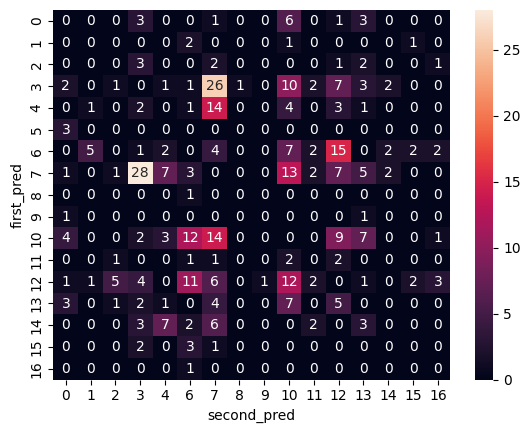

In [17]:
temp_df = test_result_df[(test_result_df['first_prob'] < 0.8)].sort_values(by='first_prob')

crosstab = pd.crosstab(temp_df['first_pred'], temp_df['second_pred'])

sns.heatmap(data = crosstab, annot=True)

In [19]:
report = classification_report(valid_targets_list, valid_preds_list, target_names=[str(i) for i in range(17)])
print(report)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        20
           1       0.86      0.92      0.89        13
           2       1.00      0.95      0.97        20
           3       0.33      0.50      0.40        12
           4       0.67      0.47      0.55        17
           5       0.94      1.00      0.97        16
           6       0.70      0.55      0.62        29
           7       0.71      0.60      0.65        20
           8       1.00      0.94      0.97        16
           9       1.00      1.00      1.00        12
          10       0.58      0.90      0.71        20
          11       1.00      0.77      0.87        13
          12       0.68      0.68      0.68        22
          13       0.82      0.82      0.82        17
          14       1.00      0.64      0.78        14
          15       1.00      0.74      0.85        19
          16       1.00      1.00      1.00        16

    accuracy              